In [1]:
import os
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import to_categorical
# import for model
from keras.models import Model
from keras import regularizers
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from keras.layers import Input, LSTM, Dense, Concatenate, Reshape, Dropout, Bidirectional, Add
from keras.callbacks import EarlyStopping

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
gpu_devices = tf.config.list_physical_devices('GPU')

In [2]:
os.makedirs(f'./BiLSTM_exps', exist_ok = True)
time_step = 5

#check file exist
lt_path = f'./BiLSTM_exps/left_data/train.csv'
lv_path = f'./BiLSTM_exps/left_data/val.csv'
lp_path = f'./BiLSTM_exps/left_data/pred.csv'
rt_path = f'./BiLSTM_exps/right_data/train.csv'
rv_path = f'./BiLSTM_exps/right_data/val.csv'
rp_path = f'./BiLSTM_exps/right_data/pred.csv'

if os.path.exists(lt_path) and os.path.exists(lv_path) and os.path.exists(lp_path)\
    and os.path.exists(rt_path) and os.path.exists(rv_path) and os.path.exists(rp_path): # if already exist, just use them
    left_train_df = pd.read_csv(lt_path)
    left_val_df = pd.read_csv(lv_path)
    left_pred_df = pd.read_csv(lp_path)
    right_train_df = pd.read_csv(rt_path)
    right_val_df = pd.read_csv(rv_path)
    right_pred_df = pd.read_csv(rp_path)
else: # else generate from features.csv
    # read every single independent piece segment into sub_dfs
    df = pd.read_csv('./data./features.csv')
    pieces = [piece for _, piece in df.groupby((df['Note_number'] == 0).cumsum())] # every element in sub_dfs is a independent piece
    left_pieces = []
    right_pieces = []

    # train:val:pred = 8:1:1
    train_ratio = 0.8
    val_ratio = 0.1
    # pred_ratio = 1 - 0.8 - 0.1 = 0.1
    train_idx = math.floor(len(pieces) * train_ratio)
    val_idx = math.floor(len(pieces) * (train_ratio + val_ratio))
    
    for piece in pieces:
        left = piece[piece['Begin_hand'] == 0.0]  # left hand part of piece
        right = piece[piece['Begin_hand'] == 1.0]  # right hand part of piece

        none_val_left = pd.DataFrame({col: [-1] * (time_step - 1) for col in left.columns})
        left = pd.concat([none_val_left, left]).reset_index(drop = True)
        none_val_right = pd.DataFrame({col: [-1] * (time_step - 1) for col in right.columns})
        right = pd.concat([none_val_right, right]).reset_index(drop = True)
        
        left_pieces.append(left)
        right_pieces.append(right)

    # shuffle pieces
    combined = list(zip(left_pieces, right_pieces))
    random.shuffle(combined)
    left_pieces, right_pieces = zip(*combined)

    left_train_df = pd.concat(left_pieces[:train_idx])
    left_val_df = pd.concat(left_pieces[train_idx:val_idx])
    left_pred_df = pd.concat(df.iloc[4:] for df in left_pieces[val_idx:])
    
    right_train_df = pd.concat(right_pieces[:train_idx])
    right_val_df = pd.concat(right_pieces[train_idx:val_idx])
    right_pred_df = pd.concat(df.iloc[4:] for df in right_pieces[val_idx:])

    # store the shuffled state
    os.makedirs(f'./BiLSTM_exps./left_data', exist_ok = True)
    left_train_df.to_csv(lt_path, index = False)
    left_val_df.to_csv(lv_path, index = False)
    left_pred_df.to_csv(lp_path, index = False)
    os.makedirs(f'./BiLSTM_exps./right_data', exist_ok = True)
    right_train_df.to_csv(rt_path, index = False)
    right_val_df.to_csv(rv_path, index = False)
    right_pred_df.to_csv(rp_path, index = False)

right_train_df = right_train_df.drop('Duration', axis = 1)
right_val_df = right_val_df.drop('Duration', axis = 1)
right_pred_df = right_pred_df.drop('Duration', axis = 1)

left_train_df = left_train_df.drop('Duration', axis = 1)
left_val_df = left_val_df.drop('Duration', axis = 1)
left_pred_df = left_pred_df.drop('Duration', axis = 1)


In [3]:
def draw(hand, history, path):
    # draw begin loss
    epochs = range(1, len(history['loss'])+1)
    plt.plot(epochs, history['loss'], label = 'Training Begin Loss')
    plt.plot(epochs, history['val_loss'], label = 'Validation Begin Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training/Validation loss in {hand} hand begin fingering')
    plt.legend(loc = 'upper right')
    min_val_loss = min(history['val_loss'])
    min_val_loss_epoch = history['val_loss'].index(min_val_loss)+1
    temp_arr = history['loss'] + history['val_loss']
    plt.annotate(f'Min Validation Loss: {min_val_loss} (Epoch {min_val_loss_epoch})',
                xy = (min_val_loss_epoch, min_val_loss),
                xytext = (len(epochs) * 0.25, (max(temp_arr) + min(temp_arr)) / 2),
                arrowprops = dict(arrowstyle = '->'))
    plt.savefig(f'{path}./training_validation_Begin_loss.png')
    plt.show()
    plt.close()
    # draw begin accuracy
    plt.plot(epochs, history['accuracy'], label = 'Training Begin Accuracy')
    plt.plot(epochs, history['val_accuracy'], label = 'Validation Begin Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Training/Validation accuracy in {hand} hand begin fingering')
    plt.legend(loc = 'lower right')
    val_accuracy_at_min_val_loss = history['val_accuracy'][min_val_loss_epoch-1]
    temp_arr = history['accuracy'] + history['val_accuracy']
    plt.annotate(f'Validation Accuracy at epoch {min_val_loss_epoch}: {val_accuracy_at_min_val_loss}',
                xy = (min_val_loss_epoch, val_accuracy_at_min_val_loss),
                xytext = (len(epochs) * 0.25, (max(temp_arr) + min(temp_arr)) / 2),
                arrowprops = dict(arrowstyle = '->'))
    plt.savefig(f'{path}./training_validation_Begin_accuracy.png')
    plt.show()
    plt.close()

In [4]:
def draw_confusion_matrix(y_true, y_pred, hand, path, labels):
    # create confusion matrix
    all_labels = range(5) # 5 fingerings in total
    matrix = confusion_matrix(y_true, y_pred, labels = all_labels)
    # plot confusion matrix
    plt.figure(figsize = (10, 8))
    ax = sns.heatmap(matrix, annot = True, cmap = 'Blues', fmt = 'g', xticklabels = labels, yticklabels = labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix - {hand} hand')
    plt.savefig(path)
    plt.show()
    plt.close()

In [5]:
# design input for time step
def df_to_X_y(df, hand, window_size = 5, features = 8):
    df_as_np = df.to_numpy()
    X = []
    y = []

    for i in range(len(df_as_np) - window_size + 1):
        # if Begin_fingering and End_fingering are not in the same hand, ignore the note to avoid the crossing hand condition
        # if (hand == 'left' and df_as_np[i+window_size-1, 13] > 0) or (hand == 'right' and df_as_np[i+window_size-1, 13] < 0):
        #    continue
        # distribute data
        row = [[a] for a in df_as_np[i:i+window_size,:features]] # get n data (ex. 0 ~ 19)
        X.append(row) # input features for 20 data
        label = df_as_np[i+window_size-1, features+1] # the 20th (index == 19) to be predicted
        y.append(abs(int(label))-1) # Begin_fingering
    
    return tf.convert_to_tensor(X), tf.convert_to_tensor(y)

In [6]:
# split input and output

# design input, use n data to predict the nth data
train_x_L, train_BeginY_L = df_to_X_y(left_train_df, 'left', time_step)
val_x_L, val_BeginY_L = df_to_X_y(left_val_df, 'left', time_step)
left_actual_fingerings = left_pred_df[['Begin_fingering']]
pred_x_L, pred_BeginY_L = df_to_X_y(left_pred_df, 'left', time_step)

train_x_R, train_BeginY_R = df_to_X_y(right_train_df, 'right', time_step)
val_x_R, val_BeginY_R = df_to_X_y(right_val_df, 'right', time_step)
right_actual_fingerings = right_pred_df[['Begin_fingering']]
pred_x_R, pred_BeginY_R = df_to_X_y(right_pred_df, 'right', time_step)

# reshape (one-hot)
train_x_L = np.reshape(train_x_L, (train_x_L.shape[0], train_x_L.shape[1], train_x_L.shape[3]))
val_x_L = np.reshape(val_x_L, (val_x_L.shape[0], val_x_L.shape[1], val_x_L.shape[3]))
pred_x_L = np.reshape(pred_x_L, (pred_x_L.shape[0], pred_x_L.shape[1], pred_x_L.shape[3]))
train_BeginY_L = to_categorical(train_BeginY_L)
val_BeginY_L = to_categorical(val_BeginY_L)
pred_BeginY_L = to_categorical(pred_BeginY_L)

train_x_R = np.reshape(train_x_R, (train_x_R.shape[0], train_x_R.shape[1], train_x_R.shape[3]))
val_x_R = np.reshape(val_x_R, (val_x_R.shape[0], val_x_R.shape[1], val_x_R.shape[3]))
pred_x_R = np.reshape(pred_x_R, (pred_x_R.shape[0], pred_x_R.shape[1], pred_x_R.shape[3]))
train_BeginY_R = to_categorical(train_BeginY_R)
val_BeginY_R = to_categorical(val_BeginY_R)
pred_BeginY_R = to_categorical(pred_BeginY_R)

In [7]:
# prepare to-predict data
## preprocessing
fingerings_mapping = {-1.0: 0, -2.0: 1, -3.0: 2, -4.0: 3, -5.0: 4,
                      1.0: 0, 2.0: 1, 3.0: 2, 4.0: 3, 5.0: 4}

left_pred_x = pred_x_L
right_pred_x = pred_x_R
left_actual_fingerings_one_hot = pred_BeginY_L
right_actual_fingerings_one_hot = pred_BeginY_R


Epoch 1/100
138/138 [==============================] - 7s 20ms/step - loss: 1.3948 - accuracy: 0.4063 - val_loss: 0.9769 - val_accuracy: 0.6223
Epoch 2/100
138/138 [==============================] - 2s 13ms/step - loss: 1.0022 - accuracy: 0.5991 - val_loss: 0.8546 - val_accuracy: 0.6638
Epoch 3/100
138/138 [==============================] - 2s 12ms/step - loss: 0.9158 - accuracy: 0.6385 - val_loss: 0.7950 - val_accuracy: 0.6887
Epoch 4/100
138/138 [==============================] - 2s 12ms/step - loss: 0.8802 - accuracy: 0.6537 - val_loss: 0.7850 - val_accuracy: 0.6934
Epoch 5/100
138/138 [==============================] - 2s 12ms/step - loss: 0.8453 - accuracy: 0.6705 - val_loss: 0.7639 - val_accuracy: 0.7044
Epoch 6/100
138/138 [==============================] - 2s 12ms/step - loss: 0.8187 - accuracy: 0.6800 - val_loss: 0.7397 - val_accuracy: 0.7169
Epoch 7/100
138/138 [==============================] - 2s 12ms/step - loss: 0.7952 - accuracy: 0.6887 - val_loss: 0.7331 - val_accuracy:

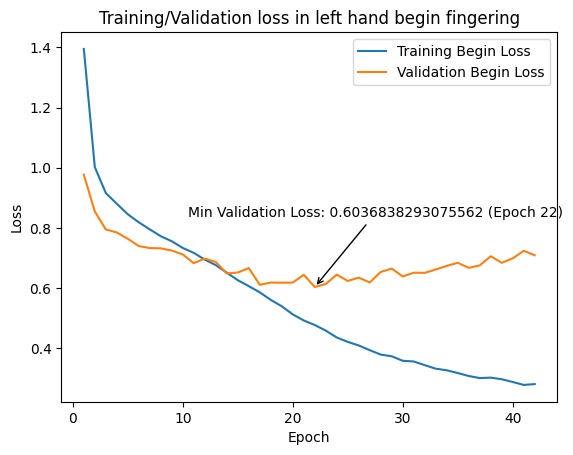

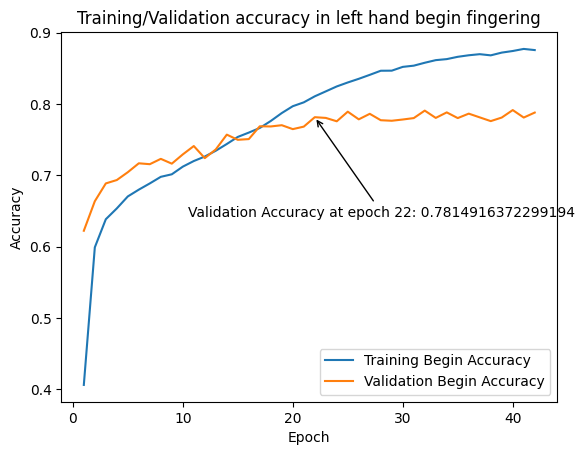

Epoch 1/100
169/169 [==============================] - 10s 22ms/step - loss: 1.5069 - accuracy: 0.3111 - val_loss: 1.2909 - val_accuracy: 0.4311
Epoch 2/100
169/169 [==============================] - 2s 14ms/step - loss: 1.1392 - accuracy: 0.5170 - val_loss: 1.1146 - val_accuracy: 0.5097
Epoch 3/100
169/169 [==============================] - 2s 15ms/step - loss: 1.0629 - accuracy: 0.5457 - val_loss: 1.0632 - val_accuracy: 0.5453
Epoch 4/100
169/169 [==============================] - 2s 15ms/step - loss: 1.0371 - accuracy: 0.5556 - val_loss: 1.0390 - val_accuracy: 0.5610
Epoch 5/100
169/169 [==============================] - 2s 15ms/step - loss: 1.0093 - accuracy: 0.5715 - val_loss: 1.0299 - val_accuracy: 0.5683
Epoch 6/100
169/169 [==============================] - 2s 15ms/step - loss: 0.9924 - accuracy: 0.5789 - val_loss: 1.0192 - val_accuracy: 0.5652
Epoch 7/100
169/169 [==============================] - 2s 15ms/step - loss: 0.9731 - accuracy: 0.5855 - val_loss: 1.0154 - val_accuracy

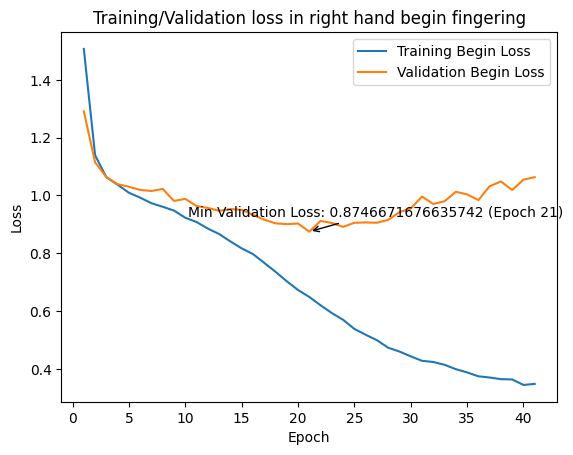

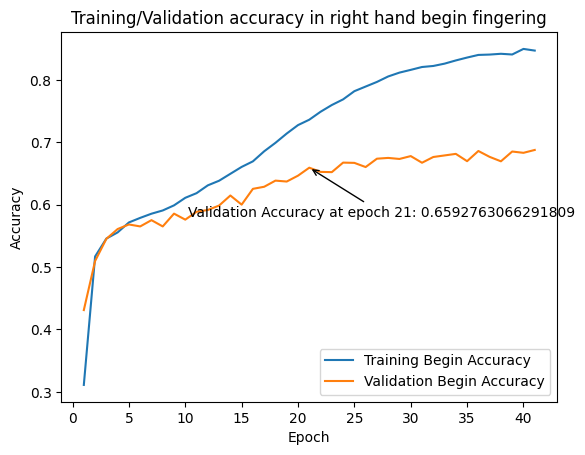

230/230 [==============================] - 2s 5ms/step


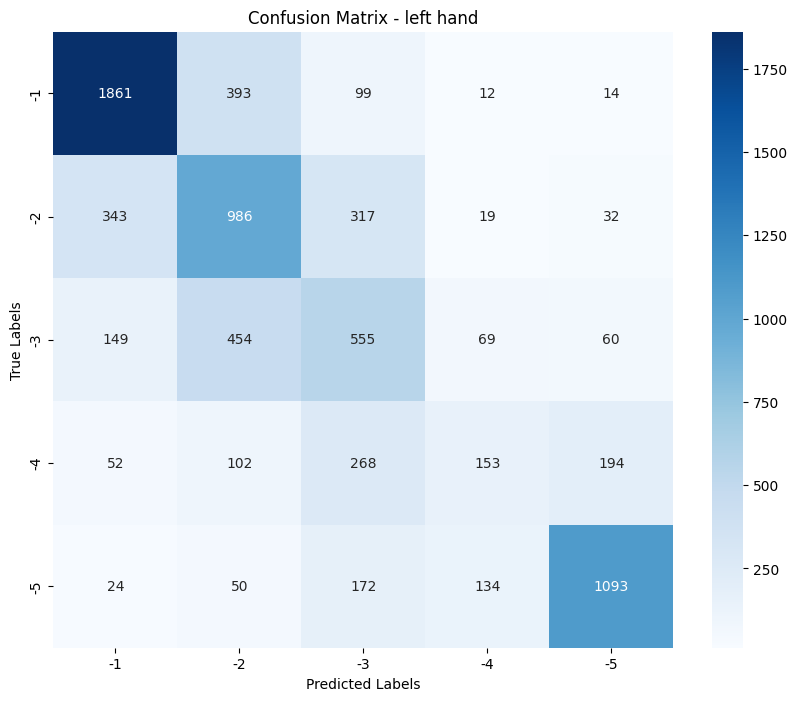

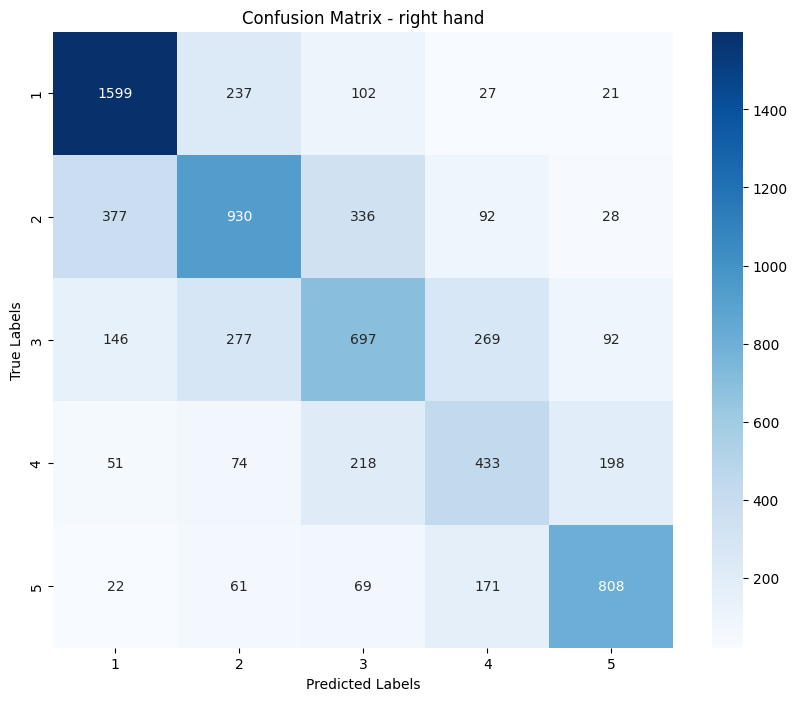

In [25]:
from keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Input, Flatten, Dropout, Add, Attention, AdditiveAttention
from keras.layers import MultiHeadAttention
from keras.models import Model

from keras.optimizers import Adam
import os
serial_num = 3
while serial_num != 4:
    os.makedirs(f'./models./exp{serial_num}', exist_ok = True)
    exp_record = {'exp_num': serial_num, 'left_val_loss': None, 'right_val_loss': None}
    for hand in ['left', 'right']:
        cur_path = f'./models./exp{serial_num}./{hand}'
        os.makedirs(cur_path, exist_ok = True)

        if hand == 'left':
            train_x = train_x_L
            val_x = val_x_L
            train_BeginY = train_BeginY_L
            val_BeginY = val_BeginY_L
        else:
            train_x = train_x_R
            val_x = val_x_R
            train_BeginY = train_BeginY_R
            val_BeginY = val_BeginY_R

        neurons = 256
        
        input_shape = (time_step, 8)
        input = Input(shape=input_shape)
        x = input

        if hand == 'left':
          x = Bidirectional(LSTM(units=neurons, return_sequences=True))(x)
          x = Bidirectional(LSTM(units=neurons, return_sequences=True))(x)
          x = Bidirectional(LSTM(units=neurons, return_sequences=True))(x)
          # x = Add()([x, x1])
          # x = MultiHeadAttention(num_heads=8, key_dim=16)(query=x, value=x, key=x)
          x = Bidirectional(LSTM(units=5))(x)

        else:
          x = Bidirectional(LSTM(units=neurons, return_sequences=True))(x)
          x = Bidirectional(LSTM(units=neurons, return_sequences=True))(x)
          # x = MultiHeadAttention(num_heads=8, key_dim=64)(query=x, value=x, key=x)
          x = Bidirectional(LSTM(units=neurons, return_sequences=True))(x)
          x = Bidirectional(LSTM(units=neurons, return_sequences=True))(x)
          # x = Add()([x, x1])
          x = Bidirectional(LSTM(units=5))(x)
          
        # 全連接層作為輸出層
        output_layer = Dense(5, activation='softmax', name='output')(x)

        # 定義模型
        model = Model(inputs=input, outputs=output_layer)

        plot_model(model, to_file = f'{cur_path}./structure.png', show_shapes = True, show_layer_names = True)
        optimizer1 = Adam(clipvalue=1.0)  # 使用梯度裁剪
        model.compile(loss = 'categorical_crossentropy',
                        optimizer = optimizer1,
                        metrics = 'accuracy')


        ## save settings
        with open(f'{cur_path}./settings.txt', 'w') as settings:
            model.summary(print_fn = lambda x: settings.write(x + '\n'))

        # train
        early_stopping = EarlyStopping(monitor = 'val_loss', patience = 20, restore_best_weights = True)
        batch = 256 
        history = model.fit(x = train_x,
                            y = train_BeginY,
                            validation_data = (val_x, val_BeginY),
                            epochs = 100,
                            batch_size = batch,
                            verbose = 1
                            ,callbacks = [early_stopping])
        
        # save final model
        model.save(f'{cur_path}./model.h5')
        # plot model
        draw(hand, history.history, cur_path)

        # record
        if hand == 'left':
            exp_record['left_val_loss'] = min(history.history['val_loss'])
        else:
            exp_record['right_val_loss'] = min(history.history['val_loss'])

    # predict
    left_model = tf.keras.models.load_model(f'./models./exp{serial_num}./left./model.h5')
    left_pred_probs_Begin = left_model.predict(left_pred_x)
    right_model = tf.keras.models.load_model(f'./models./exp{serial_num}./right./model.h5')
    right_pred_probs_Begin = right_model.predict(right_pred_x)
    ## write predicted probabilities
    predicted_path = f'./models./exp{serial_num}./predicted'
    os.makedirs(predicted_path, exist_ok = True)
    left_pred_prob_Begin_df = pd.DataFrame(left_pred_probs_Begin, columns = ['L-1', 'L-2', 'L-3', 'L-4', 'L-5'])
    left_pred_prob_Begin_df.to_csv(f'{predicted_path}./left_Begin_pred_probs.csv', index = False)
    right_pred_prob_Begin_df = pd.DataFrame(right_pred_probs_Begin, columns = ['R1', 'R2', 'R3', 'R4', 'R5'])
    right_pred_prob_Begin_df.to_csv(f'{predicted_path}./right_Begin_pred_probs.csv', index = False)
    ## transform into fingerings and output
    left_output_Begin_fingerings = np.array([[-1.0, -2.0, -3.0, -4.0, -5.0][np.argmax(row)] for row in left_pred_probs_Begin])
    left_output_df = pd.DataFrame({'Begin_fingering': left_output_Begin_fingerings})
    left_output_df.to_csv(f'{predicted_path}./left_pred.csv', index = False)
    right_output_Begin_fingering = np.array([[1.0, 2.0, 3.0, 4.0, 5.0][np.argmax(row)] for row in right_pred_probs_Begin])
    right_output_df = pd.DataFrame({'Begin_fingering': right_output_Begin_fingering})
    right_output_df.to_csv(f'{predicted_path}./right_pred.csv', index = False)

    # evaluate predicteds
    temp_left_actual_fingerings = left_actual_fingerings[4:]
    temp_right_actual_fingerings = right_actual_fingerings[4:]
    ## map fingerings
    left_y_true_mapped = temp_left_actual_fingerings['Begin_fingering'].map(fingerings_mapping)
    left_y_pred_mapped = left_output_df['Begin_fingering'].map(fingerings_mapping)
    right_y_true_mapped = temp_right_actual_fingerings['Begin_fingering'].map(fingerings_mapping)
    right_y_pred_mapped = right_output_df['Begin_fingering'].map(fingerings_mapping)
    ## confusion matrix
    draw_confusion_matrix(left_y_true_mapped, left_y_pred_mapped, 'left', f'{predicted_path}./left_matrix.png', [-1, -2, -3, -4, -5])
    draw_confusion_matrix(right_y_true_mapped, right_y_pred_mapped, 'right', f'{predicted_path}./right_matrix.png', [1, 2, 3, 4, 5])
    ## calculate accuracy
    left_output_df.reset_index(drop=True, inplace=True)
    temp_left_actual_fingerings.reset_index(drop=True, inplace=True)
    right_output_df.reset_index(drop=True, inplace=True)
    temp_right_actual_fingerings.reset_index(drop=True, inplace=True)

    left_accuracy = np.mean(left_output_df['Begin_fingering'] == temp_left_actual_fingerings['Begin_fingering'])
    right_accuracy = np.mean(right_output_df['Begin_fingering'] == temp_right_actual_fingerings['Begin_fingering'])
    ## calculate loss
    left_loss = tf.keras.losses.categorical_crossentropy(left_actual_fingerings_one_hot, left_pred_probs_Begin).numpy().mean()
    right_loss = tf.keras.losses.categorical_crossentropy(right_actual_fingerings_one_hot, right_pred_probs_Begin).numpy().mean()
    ## precision score
    left_precision = precision_score(left_y_true_mapped, left_y_pred_mapped, average = 'weighted', zero_division = 0)
    right_precision = precision_score(right_y_true_mapped, right_y_pred_mapped, average = 'weighted', zero_division = 0)
    ## recall score
    left_recall = recall_score(left_y_true_mapped, left_y_pred_mapped, average = 'weighted', zero_division = 0)
    right_recall = recall_score(right_y_true_mapped, right_y_pred_mapped, average = 'weighted', zero_division = 0)
    ## F1 score
    left_f1 = f1_score(left_y_true_mapped, left_y_pred_mapped, average = 'weighted', zero_division = 0)
    right_f1 = f1_score(right_y_true_mapped, right_y_pred_mapped, average = 'weighted', zero_division = 0)
    ## record
    with open(f'{predicted_path}./predict_evaluates.txt', 'w') as rr: # results-record
        rr.write('Left hand: \n')
        rr.write(f'\taccuracy: {left_accuracy}\n')
        rr.write(f'\tloss: {left_loss}\n')
        rr.write(f'\tPrecision score: {left_precision}\n')
        rr.write(f'\tRecall score: {left_recall}\n')
        rr.write(f'\tF1 score: {left_f1}\n')
        rr.write('Right hand: \n')
        rr.write(f'\taccuracy: {right_accuracy}\n')
        rr.write(f'\tloss: {right_loss}\n')
        rr.write(f'\tPrecision: {right_precision}\n')
        rr.write(f'\tRecall score: {right_recall}\n')
        rr.write(f'\tF1 score: {right_f1}\n')
    
    serial_num += 1